<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_l1_prox_backward_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla K80
0
0


# L1Loss backward with prox (soft thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input


class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Demonstration 1: observe gradients
### Auto differentiation vs. proximal operation

In [0]:
torch.cuda.empty_cache()
#D = torch.autograd.Variable(torch.randn(32,40000,60, device=device), requires_grad=True)
D = torch.autograd.Variable(torch.randn(2,3,5, device=device), requires_grad=True)
Dr = torch.autograd.Variable(D, requires_grad=True)

In [4]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = torch.tensor(0.5, device=device)
print('lambda = \n', ll)
#lw = ll.clone()
lw = torch.autograd.Variable(ll, requires_grad=True)
lwr = torch.autograd.Variable(ll, requires_grad=True)

# l1 norm and its backprop
from time import time
t0 = time()

l1loss = L1Loss(lw=lw)
loss = l1loss.forward(D)
loss.backward(retain_graph=True)
print('done in %.2fms' % ((time() - t0)*1000))
print('l1 loss = ', loss.item())

lw_sum_abs = torch.sum(torch.abs(lwr*Dr))
lw_sum_abs.backward(retain_graph=True)
print('sum of abs = ', lw_sum_abs.item())

lambda = 
 tensor(0.5000, device='cuda:0')
done in 2.03ms
l1 loss =  12.216056823730469
sum of abs =  12.216056823730469


### Prox of L1 norm provides gradients that cut down (sparsify) the data entries by the weight lambda while the autorgad cannot.  Imagine the gradient descent (D$-$D.grad).


In [5]:
print('data = \n', D)
print('\n Gradient of l1loss w.r.t. data by prox = \n', D.grad)
print('\n Gradient of l1loss w.r.t. lambda = \n', l1loss.lw.grad)
print('\n data = \n', Dr)
print('\n Gradient of sum of abs w.r.t. data by autograd = \n', Dr.grad)
print('\n Gradient of  sum of abs w.r.t. lambda = \n', lwr.grad)

data = 
 tensor([[[ 0.8798,  0.3375,  1.4160,  0.0515, -1.5166],
         [-0.2043, -0.9554, -0.9130, -0.4103, -1.1863],
         [-0.2003,  0.1033,  0.5579,  0.9536, -0.1383]],

        [[ 0.6580, -1.3272,  0.4761,  1.2141, -0.5073],
         [ 2.5621, -0.9250, -1.0919,  0.2060, -1.5793],
         [-1.2244,  0.3846,  0.2536, -1.9909,  0.2071]]], device='cuda:0',
       requires_grad=True)

 Gradient of l1loss w.r.t. data by prox = 
 tensor([[[ 0.5000,  0.3375,  0.5000,  0.0515, -0.5000],
         [-0.2043, -0.5000, -0.5000, -0.4103, -0.5000],
         [-0.2003,  0.1033,  0.5000,  0.5000, -0.1383]],

        [[ 0.5000, -0.5000,  0.4761,  0.5000, -0.5000],
         [ 0.5000, -0.5000, -0.5000,  0.2060, -0.5000],
         [-0.5000,  0.3846,  0.2536, -0.5000,  0.2071]]], device='cuda:0')

 Gradient of l1loss w.r.t. lambda = 
 tensor(24.4321, device='cuda:0')

 data = 
 tensor([[[ 0.8798,  0.3375,  1.4160,  0.0515, -1.5166],
         [-0.2043, -0.9554, -0.9130, -0.4103, -1.1863],
         [

# Demonstration 2: minimize l1 loss $$\mbox{Minimize}_X\|X-D\|_1$$
###Note that L1Loss is not differentiable at boundaries of orthants, so augograd cannot find the minimizer.

In [6]:
D = torch.randn(2,3,5, device=device)
print('D = \n', D)

D = 
 tensor([[[ 1.1126,  1.0968,  1.1331,  0.5044, -0.4039],
         [ 0.2640,  1.4964, -0.5245,  1.5746, -0.7028],
         [ 1.2370,  0.4282,  0.1062,  2.0900, -1.0670]],

        [[ 0.9694,  0.0224, -0.5494, -1.6887,  0.6238],
         [ 0.0361, -0.5406, -0.6262, -1.1981,  0.7198],
         [ 0.6102,  0.9520, -0.0912, -1.5640,  0.5026]]], device='cuda:0')


lambda = 
 0.5
[  1/10]: loss = 16.6619,  
[  2/10]: loss = 9.7570,  
[  3/10]: loss = 5.4964,  
[  4/10]: loss = 2.6988,  
[  5/10]: loss = 1.2219,  
[  6/10]: loss = 0.3238,  
[  7/10]: loss = 0.0000,  
[  8/10]: loss = 0.0000,  
[  9/10]: loss = 0.0000,  
[ 10/10]: loss = 0.0000,  
D = 
 tensor([[[ 1.1126,  1.0968,  1.1331,  0.5044, -0.4039],
         [ 0.2640,  1.4964, -0.5245,  1.5746, -0.7028],
         [ 1.2370,  0.4282,  0.1062,  2.0900, -1.0670]],

        [[ 0.9694,  0.0224, -0.5494, -1.6887,  0.6238],
         [ 0.0361, -0.5406, -0.6262, -1.1981,  0.7198],
         [ 0.6102,  0.9520, -0.0912, -1.5640,  0.5026]]], device='cuda:0')
X = 
 tensor([[[ 1.1126,  1.0968,  1.1331,  0.5044, -0.4039],
         [ 0.2640,  1.4964, -0.5245,  1.5746, -0.7028],
         [ 1.2370,  0.4282,  0.1062,  2.0900, -1.0670]],

        [[ 0.9694,  0.0224, -0.5494, -1.6887,  0.6238],
         [ 0.0361, -0.5406, -0.6262, -1.1981,  0.7198],
         [ 0.6102,  0.9520, -0.0912, -1.5640,  0.5026]]], devic

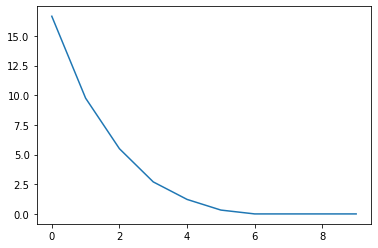

In [7]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = 0.5
print('lambda = \n', ll)

# Using L1Loss with prox
l1loss = L1Loss(lw=torch.tensor(ll))
X = torch.autograd.Variable(torch.randn(D.shape, device=device), requires_grad=True)
optimizer = torch.optim.SGD([X], lr = 1e0)

t0 = time()
num_iter = 10
display_step = 1
history_loss_prox = []
for iter in range(num_iter):
    loss = l1loss(X - D)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history_loss_prox.append(loss.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, loss.item()))

print('D = \n', D)
print('X = \n', X)
import matplotlib.pyplot as plt
plt.plot(history_loss_prox)

lambda = 
 0.5
[  1/30]: loss = 18.6613,  
[  2/30]: loss = 12.9633,  
[  3/30]: loss = 8.0190,  
[  4/30]: loss = 6.2384,  
[  5/30]: loss = 3.6880,  
[  6/30]: loss = 4.6219,  
[  7/30]: loss = 3.1880,  
[  8/30]: loss = 4.3120,  
[  9/30]: loss = 3.1880,  
[ 10/30]: loss = 4.3120,  
[ 11/30]: loss = 3.1880,  
[ 12/30]: loss = 4.3120,  
[ 13/30]: loss = 3.1880,  
[ 14/30]: loss = 4.3120,  
[ 15/30]: loss = 3.1880,  
[ 16/30]: loss = 4.3120,  
[ 17/30]: loss = 3.1880,  
[ 18/30]: loss = 4.3120,  
[ 19/30]: loss = 3.1880,  
[ 20/30]: loss = 4.3120,  
[ 21/30]: loss = 3.1880,  
[ 22/30]: loss = 4.3120,  
[ 23/30]: loss = 3.1880,  
[ 24/30]: loss = 4.3120,  
[ 25/30]: loss = 3.1880,  
[ 26/30]: loss = 4.3120,  
[ 27/30]: loss = 3.1880,  
[ 28/30]: loss = 4.3120,  
[ 29/30]: loss = 3.1880,  
[ 30/30]: loss = 4.3120,  
D = 
 tensor([[[ 1.1126,  1.0968,  1.1331,  0.5044, -0.4039],
         [ 0.2640,  1.4964, -0.5245,  1.5746, -0.7028],
         [ 1.2370,  0.4282,  0.1062,  2.0900, -1.0670]]

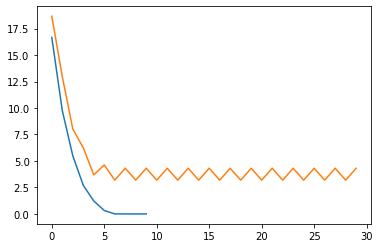

In [8]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = 0.5
print('lambda = \n', ll)

# Using sum of abs with autogradient
l1loss = lambda x: torch.sum(torch.abs(x)*ll)
X = torch.autograd.Variable(torch.randn(D.shape, device=device), requires_grad=True)
optimizer = torch.optim.SGD([X], lr = 1e0)

t0 = time()
num_iter = 30
display_step = 1
history_loss = []
for iter in range(num_iter):
    loss = l1loss(X - D)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history_loss.append(loss.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, loss.item()))

print('D = \n', D)
print('X = \n', X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history_loss_prox)
plt.plot(history_loss)